In [153]:

#

ERROR: Could not find a version that satisfies the requirement scipy.spacial (from versions: none)
ERROR: No matching distribution found for scipy.spacial


In [ ]:

#system
from pathlib import Path
import swifter
import json

# standard 

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from scipy.spatial import cKDTree # for point interpolation

# Geospacial 

import geojson
import geopandas
import shapely

# Config Variables  

# Instantiating this for importing geospacial data
# A dataframe with extended geometric capabilties
gdf = geopandas.GeoDataFrame

DATA_DIR = Path('/home/jentlejames/Datasets/BikeLA')
PROJECT_DIR = Path('/home/jentlejames/Projects/Data/Data Analysis Projects/BikeLA')

# Bounding Box for GPS COrodinates
# Latitude and Longitude

limitNorth = 34.25 #34.2 + 0.5 # Grapevine
limitSouth = 33.6 # OK #- 0.2 # Korean War Memorial / Port of LA
limitEast = -117.75 #+ 0.5# Mt Baldy
limitWest = -118.85# -0.5 # Malibu Point Dume

laCountyBoundingBox = shapely.Polygon([(limitWest,limitSouth),(limitWest,limitNorth),(limitEast,limitNorth),(limitEast,limitSouth)])

## Importing the base layer 

In [2]:
#geojson.load(str(DATA_DIR/'CA_HQ_Transit_Areas.geojson'))
base_layer = geopandas.read_file(DATA_DIR/'base_layer_zip_codes.json')

[]

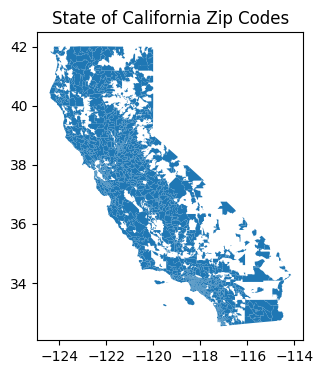

In [3]:
fig,ax = plt.subplots(figsize=(4,4))
base_layer.plot(ax=ax)
plt.title('State of California Zip Codes')
plt.plot()

### Clipping map down to LA County Level

Bounding a box based on the limits used before

(Code Hidden) 

In [4]:
# Removing Null Values
base_layer.drop(['cnty_fips','county','tract','tract_id','census_key'],axis=1,inplace=True)

In [5]:
# Bounding Box for County Data  using first principles numpy approach
#laIdx = np.where((base_layer['latitude'] < limitNorth) &
#         (base_layer['latitude'] > limitSouth)  &
#         (base_layer['longitude'] > limitWest) &
#         (base_layer['longitude'] < limitEast),
#        True,False)

#base_layer = base_layer[laIdx].copy()
 
# A better, more optomized approach found later in the project
base_layer = base_layer.clip(laCountyBoundingBox)

### Plot

Now the plot has been clipped down to Los Angeles County where the bikes are

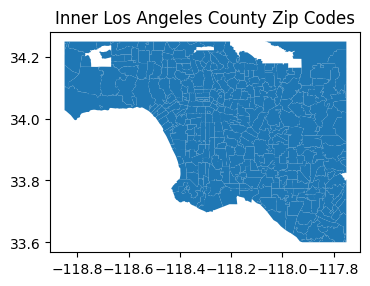

In [6]:
fig,ax = plt.subplots(figsize=(4,4))
base_layer.plot(ax=ax)
plt.title('Inner Los Angeles County Zip Codes')
plt.show()
# The White Areas represent nature preseves where
# Nobody lives, either mountains or wetlands

In [7]:
# Checking a data point, which is where I went to University 
base_layer[base_layer['zcta'] == '90045']

,id,objectid,zcta,zcta_key,latitude,longitude,tot_pop,age_under5,age_5to9,age_10to14,...,hu_vac,hu_vac_ren,hu_vac_sea,hu_occ_own,hu_occ_o_1,hu_occ_ren,hu_occ_r_1,shape_area,shape_len,geometry
1372,dc841dq9031.1373,1373,90045,0690045,33.95295,-118.400148,39480,2102,1922,1879,...,903,533,90,8077,20746,7147,15367,2.777983e+07,32703.451206,"POLYGON ((-118.42529 33.95394, -118.42697 33.9..."


# Additional Data Sources

Collating Data according to Five Categories


1. Transit Information 

    a. Bikeways
    b. Biek Routes
    c. Bottlenecks
    d. HQ Transit Areas
    e. HQ Transit Stops

2. Demographic data

    a. Income Per Captital
    b. Health Data
    c. CDC Health Data
    d. Traffic Data-ZCTA 

3. Psychological Effects Data

    a. Homeless Data
    b. Healthhy Places Index
    c. Park Data
    d. Coffee Shops
    e. Pollution Data

4. Crime Data

    a. 2010- 2019 raw crime data

5. 

## A. Transit Information

### 1. HQ Transit Corridors

Source: State of California 
https://gis.data.ca.gov/datasets/863e61eacbf3463ab239beb3cee4a2c3_0/explore?location=33.962088%2C-118.069318%2C10.98

In [8]:
gdf_CaTransit = gdf.from_file(DATA_DIR/'Transit'/'CA_HQ_Transit_Areas.geojson')

In [9]:


gdf_CaTransit = gdf_CaTransit.clip(laCountyBoundingBox)
gdf_CaTransit.shape


(6785, 11)

Text(0.5, 1.0, 'High Quality Public Transit Corridors in LA County')

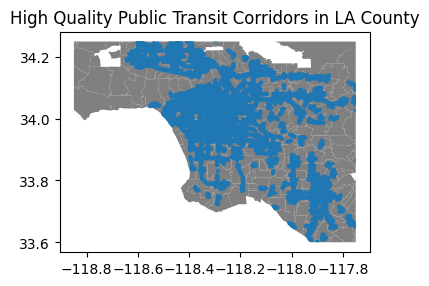

In [10]:
fig,ax = plt.subplots(figsize=(4,4))
base_layer.plot(ax=ax,color="grey")
gdf_CaTransit.geometry.plot(ax=ax)
plt.title('High Quality Public Transit Corridors in LA County')

### Exploration
After Culling down the dataset to only encompass the Los Angeles Area,
let's explore what kind of variables are present in the dataset


In [11]:
gdf_CaTransit.agency_primary.unique()

array(['Irvine Shuttle', 'Catalina Flyer', ' ', 'Metrolink',
       'Anaheim Regional Transportation', 'Riverside Transit Agency',
       'Metro', 'Los Angeles Department of Transportation',
       'Torrance Transit System', 'Compton Renaissance Transit Service',
       'Avocado Heights/Bassett/West Valinda Shuttle',
       'Montebello Bus Lines', 'Foothill Transit', 'DowneyLINK',
       'Norwalk Transit System', 'Lynwood Breeze',
       'Commerce Municipal Bus Lines',
       'Palos Verdes Peninsula Transit Authority', 'Beach Cities Transit',
       'Culver CityBus', 'Big Blue Bus', 'LAX FlyAway',
       'Santa Clarita Transit', 'Antelope Valley Transit Authority',
       'Go West Shuttle', 'OmniTrans', 'Alhambra Community Transit',
       'El Monte Transportation Division', 'Pasadena Transit',
       'City of West Hollywood', 'Glendale Beeline', 'Burbank Bus',
       'Glendora Transportation Division',
       'Ventura County Transportation Commission', 'Ojai Trolley'],
      dtype=obj

There is a large array of different transit authorities that service the LA Are

In [12]:
gdf_CaTransit.hqta_type.value_counts()

major_stop_bus      6177
hq_corridor_bus      424
major_stop_rail      128
major_stop_brt        55
major_stop_ferry       1
Name: hqta_type, dtype: int64

Major Stop

brt or Bus Rapid Transit are bus lines integrated into the major rail stops


In [13]:
gdf_CaTransit.hqta_details.value_counts()

intersection_2_bus_routes_same_operator          3767
intersection_2_bus_routes_different_operators    2410
stop_along_hq_bus_corridor_single_operator        424
major_stop_rail_single_operator                   128
major_stop_brt_single_operator                     55
major_stop_ferry_single_operator                    1
Name: hqta_details, dtype: int64

Here, these two variables are highly correlated, so it would be good to bring them down in cardinality

For this, it is worth merging the brt into the rail, to signify that it is a part of the LA Metro train system. 

This will merge LA_Metro, with LA_Metrolink, and BRT into the METRO category.

Then, merging the city buses into one category, and leaving the LA metro system,
into another will reduce the cardinality.



For the time being, I'll be merging the bus routes into a single

In [14]:
# Merging the public transit types

metroConditions = (gdf_CaTransit['hqta_type'] == 'major_stop_brt' )|(gdf_CaTransit['hqta_type'] =='major_stop_rail')

gdf_CaTransit['hqta_type'] = np.where(metroConditions,'la_metro',gdf_CaTransit['hqta_type'])

In [15]:
gdf_CaTransit.hqta_type.unique()

array(['major_stop_bus', 'major_stop_ferry', 'hq_corridor_bus',
       'la_metro'], dtype=object)

In [16]:
#gdf_CaTransit[gdf_CaTransit['hqta_type'] == 'la

In [17]:
largeTransitOperators = ['Metro','Los Angeles Department of Transportation','LAX FlyAway', ' ']
smallTransitOperators =  list(gdf_CaTransit['agency_primary'].unique())

In [18]:
# Creating lists of transit operators in 
# order to bring down cardinality in 
# This feature

largeTransitOperators = ['Metro','Los Angeles Department of Transportation','LAX FlyAway','Metrolink']
smallTransitOperators =  list(gdf_CaTransit['agency_primary'].unique())

smallTransitOperators.remove(largeTransitOperators[0])
smallTransitOperators.remove(largeTransitOperators[1])
smallTransitOperators.remove(largeTransitOperators[2])

smallTransitOperators.remove(' ')

In [19]:
largeTransitIdx = gdf_CaTransit['agency_primary'].isin(largeTransitOperators)
operatorBlank = gdf_CaTransit['agency_primary'] == ' '
smallTransitIdx = gdf_CaTransit['agency_primary'].isin(smallTransitOperators)

primaryAgencyConditionList = [operatorBlank,largeTransitIdx,smallTransitIdx]
primaryAgencyChoicelist = [' ', 'la_city','not_la_city']

gdf_CaTransit['agency_primary'] =  np.select(primaryAgencyConditionList,primaryAgencyChoicelist,'')

In [20]:
largeTransitIdx = gdf_CaTransit['agency_primary'].isin(largeTransitOperators)
operatorBlank = gdf_CaTransit['agency_primary'] == ' '
smallTransitIdx = gdf_CaTransit['agency_primary'].isin(smallTransitOperators)

secondaryAgencyConditionList = [operatorBlank,largeTransitIdx,smallTransitIdx]
secondaryAgencyChoicelist = [' ', 'la_city','not_la_city']

gdf_CaTransit['agency_secondary'] =  np.select(secondaryAgencyConditionList,secondaryAgencyChoicelist,'')

In [21]:
gdf_CaTransit['agency_primary'].value_counts()

la_city        4348
not_la_city    2013
                424
Name: agency_primary, dtype: int64

Now, the cardinary has been reduced in this variable so that insights can
be produced. The blank values are for shapes outlining bus routes that defy the conventions of the rest of the document. It is ok to leave them be in this case

In [22]:
gdf_CaTransit.columns

Index(['OBJECTID', 'itp_id_primary', 'itp_id_secondary', 'agency_primary',
       'agency_secondary', 'hqta_type', 'hqta_details', 'route_id',
       'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [23]:
# Removing this data to not clutter up
# The data merged later 
colsToDropCaTransit = ['OBJECTID','itp_id_primary','itp_id_secondary','hqta_details']

gdf_CaTransit.drop(columns =colsToDropCaTransit,axis=1,inplace=True)

In [24]:
gdf_CaTransit.head()

,agency_primary,agency_secondary,hqta_type,route_id,Shape_Length,Shape_Area,geometry
6928,not_la_city,,major_stop_bus,1,0.043901,0.000151,"POLYGON ((-117.87049 33.60964, -117.87062 33.6..."
7124,not_la_city,,major_stop_bus,55,0.043901,0.000151,"POLYGON ((-117.87033 33.61026, -117.87046 33.6..."
7178,not_la_city,,major_stop_bus,57,0.043901,0.000151,"POLYGON ((-117.86701 33.61185, -117.86714 33.6..."
7177,not_la_city,,major_stop_bus,57,0.043902,0.000151,"POLYGON ((-117.86928 33.61196, -117.86941 33.6..."
6925,not_la_city,,major_stop_bus,1,0.043902,0.000151,"POLYGON ((-117.86797 33.61198, -117.86810 33.6..."


##

#### Filter Down of Data 

### HQ Transit Corridors Plot

Text(0.5, 1.0, 'High Quality Public Transit Corridors in LA County')

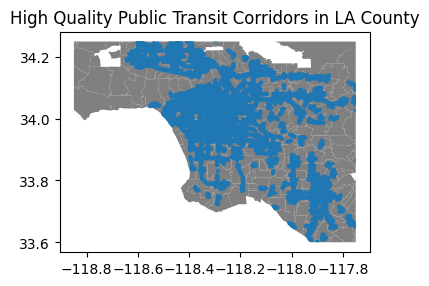

In [25]:
fig,ax = plt.subplots(figsize=(4,4))
base_layer.plot(ax=ax,color="grey")
gdf_CaTransit.geometry.plot(ax=ax)
plt.title('High Quality Public Transit Corridors in LA County')

### 2. HQ Transit Stops
<hr>

Source: CA HQ Transit Stops from State of California, Nov 24 2022

https://gis.data.ca.gov/datasets/f6c30480f0e84be699383192c099a6a4_0/explore?location=33.976005%2C-118.362206%2C11.10

In [26]:
gdf_ca_transit_stops = gdf.from_file(DATA_DIR/'Transit'/'CA_HQ_Transit_Stops.geojson')

In [27]:

gdf_ca_transit_stops =  gdf_ca_transit_stops.clip(laCountyBoundingBox)


#### Exploring Transit Stop Data

In [28]:
gdf_ca_transit_stops.shape

(25514, 10)

In [29]:
gdf_CaTransit.shape

(6785, 7)

In [30]:
gdf_ca_transit_stops.hqta_details.value_counts()

stop_along_hq_bus_corridor_single_operator       19190
intersection_2_bus_routes_same_operator           3741
intersection_2_bus_routes_different_operators     2401
major_stop_rail_single_operator                    127
major_stop_brt_single_operator                      54
major_stop_ferry_single_operator                     1
Name: hqta_details, dtype: int64

### 3. Bikeway data

https://gisdata-scag.opendata.arcgis.com/datasets/SCAG::bike-routes-scag-region/explore?location=34.200862%2C-116.986800%2C8.82

In [31]:
# Loading the Bike Data
gdf_bikeroutes = geopandas.read_file(DATA_DIR/'Transit'/'Bike_Routes_SCAG_Region.geojson')

In [32]:
gdf_bikeroutes.head()

,OBJECTID,NAME,CITY,COUNTY,CLASS_E,FACDES_E,CLASS_P,FACDES_P,INSTALL_DA,MILES_1,...,APP_ID,FTIP_ID,RBN,NOTES,YEAR,Shapelen,BIKEDIR,LANECOUNT,PLAN_NAME,geometry
0,1,Grand Ave,Diamond Bar,Los Angeles County,2,,0,,,0.00173,...,0,0,,,2019,2.795049,,0,San Bernardino County Non-Motorized Transporta...,"LINESTRING (-117.79115 33.99470, -117.79112 33..."
1,2,Hellman Ave,Eastvale,Riverside County,0,,1,,,1.01910,...,0,0,,,2019,1640.092825,,0,San Bernardino County Non-Motorized Transporta...,"MULTILINESTRING ((-117.61100 33.96526, -117.61..."
2,3,Hellman Ave,Eastvale,Riverside County,0,,2,,,1.24939,...,0,0,,,2019,2010.700514,,0,San Bernardino County Non-Motorized Transporta...,"MULTILINESTRING ((-117.61092 33.94943, -117.61..."
3,4,Sierra Ave,Jurupa Valley,Riverside County,0,,2,,,0.02935,...,0,0,,Added based on local input (City of Fontana),2019,47.236466,,0,San Bernardino County Non-Motorized Transporta...,"LINESTRING (-117.43325 34.03418, -117.43300 34..."
4,5,Cactus Ave,Jurupa Valley,Riverside County,0,,2,,,0.01826,...,0,0,,,2019,29.401198,,0,San Bernardino County Non-Motorized Transporta...,"LINESTRING (-117.38328 34.03411, -117.38328 34..."


#### Reducing the data down to LA County

This job is made considerably easier from having the county listed in this 
data

In [33]:
gdf_bikeroutes.COUNTY.value_counts()

Los Angeles County       24499
Riverside County          6598
Orange County             3258
Ventura County            2930
San Bernardino County     2182
Imperial County            628
                             4
Name: COUNTY, dtype: int64

In [34]:
gdf_bikeroutes = gdf_bikeroutes[gdf_bikeroutes['COUNTY'] == 'Los Angeles County']

In [35]:
gdf_bikeroutes = gdf_bikeroutes.clip(laCountyBoundingBox)

In [36]:
### Here are the 

#### It appears like this is too

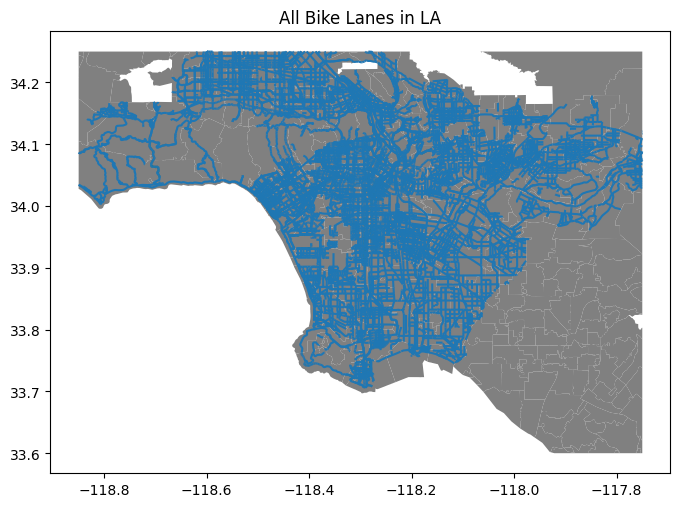

In [37]:
fig,ax = plt.subplots(figsize=(8,8))
base_layer.plot(ax=ax,color="grey")
gdf_bikeroutes.plot(ax=ax)
plt.title('All Bike Lanes in LA')
plt.show()

#### Preliminary Exploration

Goal: See how the data can be merged

Understand the variables better, reduce cardinality when possible

In [38]:
gdf_bikeroutes.columns

Index(['OBJECTID', 'NAME', 'CITY', 'COUNTY', 'CLASS_E', 'FACDES_E', 'CLASS_P',
       'FACDES_P', 'INSTALL_DA', 'MILES_1', 'ON_', 'FROM_', 'TO_', 'PLAN_ADOP',
       'PLAN_JURIS', 'PLAN_URL', 'APP_ID', 'FTIP_ID', 'RBN', 'NOTES', 'YEAR',
       'Shapelen', 'BIKEDIR', 'LANECOUNT', 'PLAN_NAME', 'geometry'],
      dtype='object')

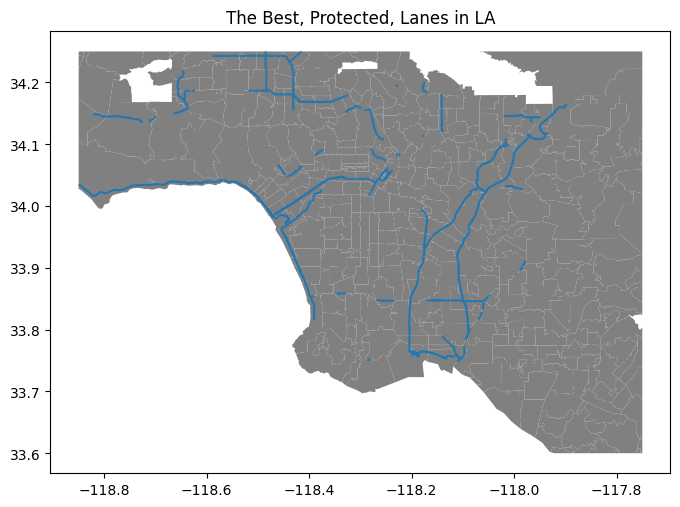

In [39]:
fig,ax = plt.subplots(figsize=(8,8))
base_layer.plot(ax=ax,color="grey")
gdf_bikeroutes[gdf_bikeroutes.RBN == 'Existing'].plot(ax=ax)
plt.title('The Best, Protected, Lanes in LA')
plt.show()

It appeas that the dataset includes any roads in the county

<AxesSubplot: >

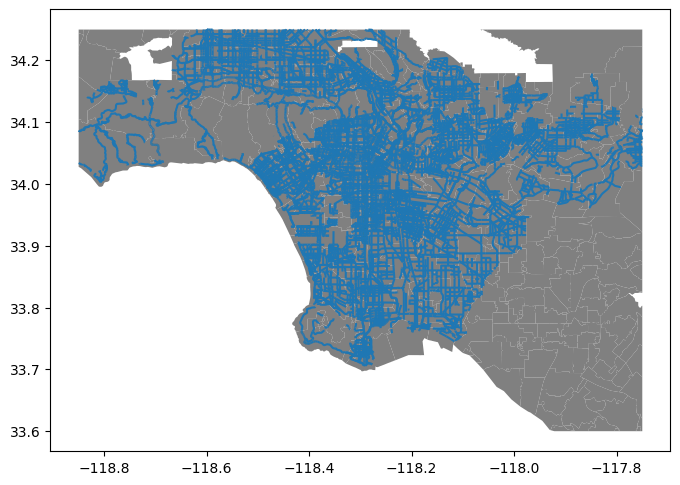

In [40]:
fig,ax = plt.subplots(figsize=(8,8))
base_layer.plot(ax=ax,color="grey")
gdf_bikeroutes[gdf_bikeroutes.RBN == ' '].plot(ax=ax)

#### Bike Lane Class

Class I Bikeways

Class I includes bike paths and shared-use paths. These paths do not allow any motorized vehicles. But bicycles, pedestrians, and other human-powered vehicles must share the path. Class I bike paths are separate from roadways and have minimal crossflow by motorists.
Class II Bikeways

Class II includes bike lanes. These lanes share the roadways with motorized vehicles. Markings on the pavement identify Class II bike lanes. Pedestrians and motorists can cross Class II bike lanes, making them one of the most dangerous forms of bikeways.
Class III Bikeways

Class III includes bike routes. These are streets designated for sharing by bicycles and motor vehicles. But they include restrictions that make them safer and more friendly for bicycles.

For example, a Class III bike route might have a 15-mile-per-hour speed limit to discourage its use by motorists and to keep cyclists safe from motorists who choose to use it.
Class IV Bikeways

Class IV includes separated bikeways. These bikeways share the roads with cars. But a physical barrier separates vehicle traffic from bike traffic. Planters, walls, posts, and other types of barriers keep vehicles from using or crossing class IV separated bikeways.

For this round, I am going to only take classified  bike ways
However, I'll also eliminate Class II Bikeways
Due to it being unwelcoming and unsafe without a road bike that
can maintain a high speed


#### Culling Down the Data

Here, it is necessary to find bike lanes that 
show an area is suitable for bike riding based
on the classes. Class 2 should be eliminated based
on the paragraph above

In [41]:
gdf_bikeroutes_designated = gdf_bikeroutes[gdf_bikeroutes.CLASS_E.isin([1,3,4])].index

In [42]:
# Bitwise merge of two indicies to obtain the best bike lanes

# Here, I am adding another Category, which are the bike routes listed in the city
# master plan as existing

gdf_bikeroutes_designated =  gdf_bikeroutes_designated | gdf_bikeroutes[gdf_bikeroutes.RBN == 'Existing'].index 

In [43]:
gdf_bikeroutes = gdf_bikeroutes.loc[gdf_bikeroutes_designated].reset_index(drop=True).copy()

In [44]:

gdf_bikeroutes.shape

(3359, 26)

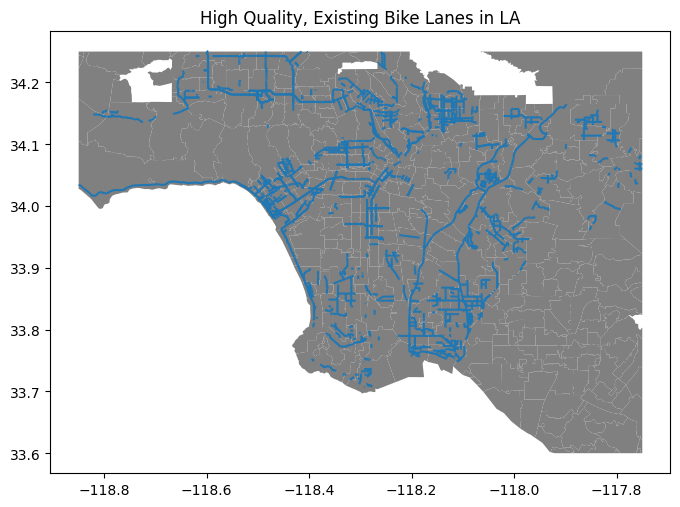

In [45]:
fig,ax = plt.subplots(figsize=(8,8))
base_layer.plot(ax=ax,color="grey")
gdf_bikeroutes.plot(ax=ax)
plt.title('High Quality, Existing Bike Lanes in LA')
plt.show()

# Data Collection Part 2: ZCTA CENSUS Data
<hr></hr>

In this section, is where we will merge our geospacial data with geotagged data.

In this, we are going to perform the merge based on a shared key, which
will be the zip codes in Los Angeles County

In [46]:
# Setting a key from the base map, to make our data much smaller

# The base layer contains spacial information 
laCountyZipCodes =  base_layer.zcta.unique()
print(laCountyZipCodes[0:5])

['92651' '92706' '92866' '92868' '92869']


### Traffic Volume 

https://www.icpsr.umich.edu/web/ICPSR/studies/38584#



In [47]:
import pyreadstat

df_traffic, meta_traffic =  pyreadstat.read_dta(DATA_DIR/'Transit'/'traffic_ztca.dta')

In [48]:
# Always Checking the shape
df_traffic.shape

(675326, 22)

In [49]:
# Filtering down the data to only LA County 
df_traffic =  df_traffic[df_traffic.zcta19.isin(laCountyZipCodes)]

In [50]:
# Sorting through finding the latest record for each zip code
# Using a groupby statement
# The tail is taken because it represents the latest observation of a zip code
df_traffic = df_traffic.sort_values('year').groupby('zcta19').tail(1)

[]

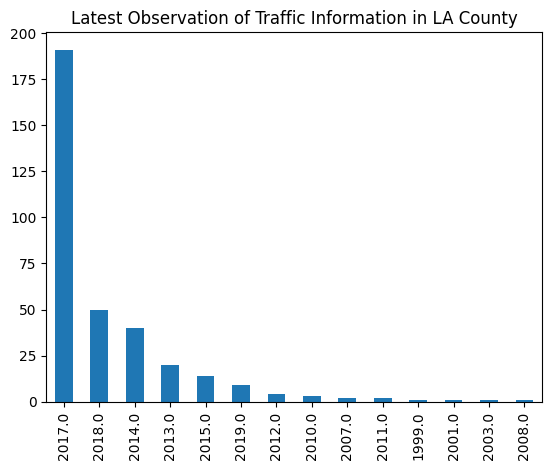

In [51]:
df_traffic.year.value_counts().plot(kind='bar',title='Latest Observation of Traffic Information in LA County')
plt.plot()

This shows that the vast majority of the data is from the last 10 years. 
However, I am not example comfortable with how old some of it appears.
I will keep an eye on this later on when the data gets filtered down
more 

### Selecting Relevant Data for Bicyclists

source: https://www.openicpsr.org/openicpsr/project/160262/version/V1/view?path=/openicpsr/160262/fcr:versions/V1.3/NaNDA_Traffic_Volume_by_Census_Tract_1963-2019_v1-0.pdf&type=file#

Here, I can get rid of the highway traffic for obvious reasons.
Instead, I'm going to focus on the intersection traffic, as well as
the the median traffic


In [52]:
df_traffic.columns

Index(['zcta19', 'year', 'intp_flag', 'i_mean_traffic', 'i_min_traffic',
       'i_max_traffic', 'i_count_traffic', 'i_total_traffic',
       'i_mean_hw_traffic', 'i_min_hw_traffic', 'i_max_hw_traffic',
       'i_count_hw_traffic', 'i_total_hw_traffic', 'i_mean_nonhw_traffic',
       'i_min_nonhw_traffic', 'i_max_nonhw_traffic', 'i_count_nonhw_traffic',
       'i_total_nonhw_traffic', 'count_intersections',
       'i_mean_traf_per_intersection', 'i_mean_hw_traf_per_intersection',
       'i_mean_nh_traf_per_intersection'],
      dtype='object')

In [53]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 617180 to 626625
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   zcta19                           339 non-null    object 
 1   year                             339 non-null    float64
 2   intp_flag                        339 non-null    float64
 3   i_mean_traffic                   339 non-null    float64
 4   i_min_traffic                    339 non-null    float64
 5   i_max_traffic                    339 non-null    float64
 6   i_count_traffic                  339 non-null    float64
 7   i_total_traffic                  339 non-null    float64
 8   i_mean_hw_traffic                35 non-null     float64
 9   i_min_hw_traffic                 35 non-null     float64
 10  i_max_hw_traffic                 35 non-null     float64
 11  i_count_hw_traffic               339 non-null    float64
 12  i_total_hw_tra

In [54]:
relevantTrafficFeatures = ['zcta19','year','i_mean_nonhw_traffic','i_mean_nh_traf_per_intersection','count_intersections','i_total_nonhw_traffic']

In [55]:
# None of these values were interpolated
df_traffic.intp_flag.value_counts()

0.0    339
Name: intp_flag, dtype: int64

In [56]:
df_traffic = df_traffic[relevantTrafficFeatures].reset_index(drop=True).copy()

In [57]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   zcta19                           339 non-null    object 
 1   year                             339 non-null    float64
 2   i_mean_nonhw_traffic             331 non-null    float64
 3   i_mean_nh_traf_per_intersection  330 non-null    float64
 4   count_intersections              339 non-null    float64
 5   i_total_nonhw_traffic            339 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.0+ KB


In [58]:
df_traffic.sample(3)

,zcta19,year,i_mean_nonhw_traffic,i_mean_nh_traf_per_intersection,count_intersections,i_total_nonhw_traffic
70,90270,2014.0,34736.0,175.434341,198.0,34736.0
240,92866,2017.0,204400.0,617.522644,331.0,613200.0
167,90742,2017.0,44350.0,452.551025,98.0,44350.0


## Demographic Data



### Median Household Income 

https://gisdata-scag.opendata.arcgis.com/datasets/SCAG::median-household-income-2016/explore?location=33.860046%2C-117.589060%2C10.03

In [59]:
gdf_median_household_income = geopandas.read_file(DATA_DIR/'Demographics'/'Median_Household_Income_(2016).geojson')

In [60]:
gdf_median_household_income.sample(1)

,OBJECTID,GEOID10,COUNTYFP10,TRACTCE10,Cnty_Name,City_Name,ZIP,Acres,SqMi,Pop_16,...,UnEmp_Rate,Emp_15,Emp_Den,Emp_Src,Income_Pct,Income_Rpt,Income_Src,Under19_Pc,MHI2016,geometry
1907,1908,06037302503,037,302503,Los Angeles,Glendale,91205,80.672765,0.126051,4443,...,0.147863,638,5061.435542,LEHD 2015,36068,2011-2015,ACS_15_5YR_DP03,21.4,36052.0,"POLYGON ((-118.25062 34.13717, -118.25043 34.1..."


### Health Data

source: https://data.cdc.gov/browse?tags=zcta

CrudePrev = Crude Prevelance = Mean within a confidence interval

In [61]:
df_cdc_health = pd.read_csv(DATA_DIR/'Demographics'/'US_ZCTA.csv')


In [62]:
df_cdc_health.sample()

,ZCTA5,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BINGE_CrudePrev,BINGE_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
18357,50569,836,9.8,"( 8.1, 11.9)",28.3,"(27.1, 29.5)",21.5,"(20.7, 22.2)",34.4,"(33.1, 35.8)",...,"(35.9, 39.2)",12.3,"(11.2, 13.5)",32.8,"(31.7, 33.8)",3.7,"( 3.3, 4.1)",13.6,"(10.6, 17.4)",POINT (-94.13878692 42.40305569)


In [63]:
df_cdc_health.columns

Index(['ZCTA5', 'TotalPopulation', 'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI',
       'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev',
       'BINGE_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CANCER_CrudePrev',
       'CANCER_Crude95CI', 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI',
       'CERVICAL_CrudePrev', 'CERVICAL_Crude95CI', 'CHD_CrudePrev',
       'CHD_Crude95CI', 'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI',
       'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DEPRESSION_CrudePrev', 'DEPRESSION_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'GHLTH_CrudePrev', 'GHLTH_Crude95CI',
       'HIGHCHOL_CrudePrev', 'HIGHCHOL_Cru

In [64]:
df_cdc_health['Geolocation']

0        POINT (-74.53173709 39.48730537)
1         POINT (-74.3462755 40.64888869)
2        POINT (-75.16934975 40.69233901)
3        POINT (-73.99666187 40.84708222)
4        POINT (-74.07252197 40.16876396)
                       ...               
32404    POINT (-118.8177028 34.05791275)
32405     POINT (-117.104794 33.81232975)
32406    POINT (-121.6852387 48.59322161)
32407    POINT (-105.6278913 36.60796943)
32408      POINT (-121.2543305 38.651948)
Name: Geolocation, Length: 32409, dtype: object

In [65]:
df_cdc_health['ZCTA5'] = df_cdc_health['ZCTA5'].astype(str)

In [66]:
relevantHealthFeatures = ['ZCTA5','Geolocation','TotalPopulation'
            ,'OBESITY_CrudePrev','DEPRESSION_CrudePrev','SLEEP_CrudePrev',
            'CSMOKING_CrudePrev','BPHIGH_CrudePrev','CANCER_Crude95CI']

In [67]:
df_cdc_health = df_cdc_health[relevantHealthFeatures].copy()

## Psychological Factors


## Homelessness 

https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/


In [68]:
import shapefile

r = shapefile.Reader(DATA_DIR/'Streets'/'HC_2020_CensusTractSplits'/'HC_2020_CensusTractSplits_20220916')

In [69]:
gdf_homeless_count = geopandas.read_file(DATA_DIR/'Streets'/'HC_2020_CensusTractSplits'/'HC_2020_CensusTractSplits_20220916.shp')

In [70]:
 # Bounding box 



In [71]:
gdf_homeless_count = gdf_homeless_count.to_crs('epsg:4326')

gdf_home

### Healthy Places Index 

https://gisdata-scag.opendata.arcgis.com/datasets/SCAG::healthy-places-index-hpi-2017/explore?location=34.047839%2C-118.410567%2C13.07

In [72]:
gdf_healthy_places = geopandas.read_file(DATA_DIR/'Psych'/'Healthy_Places_Index_(HPI)_2017.geojson')

In [73]:
gdf_healthy_places =  gdf_healthy_places.clip(laCountyBoundingBox)

In [74]:
gdf_healthy_places['ZIP'] = gdf_healthy_places['ZIP'].astype(str)

<AxesSubplot: >

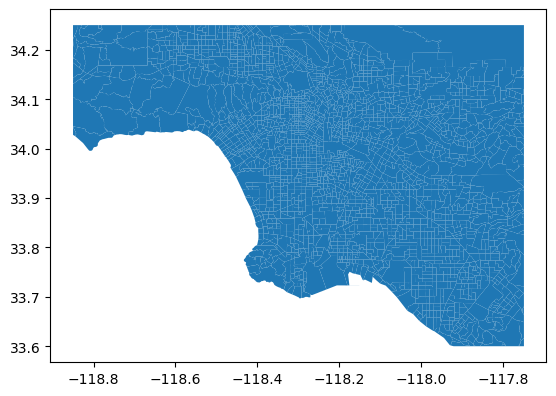

In [75]:
gdf_healthy_places.plot()

In [76]:
gdf_healthy_places.columns

Index(['OBJECTID', 'GEOID10', 'Acres', 'COUNTYFP10', 'TRACTCE10', 'County_Nam',
       'City_Name', 'ZIP', 'INTPTLAT10', 'INTPTLON10', 'Pop_10', 'UrbanType',
       'HPI2_pctil', 'HPI2_pct_1', 'Top25', 'Quin', 'Quar', 'Version',
       'Sprmrkts', 'Sprmrkt_Pc', 'Sprmrkt_Rp', 'Sprmrkt_Sr', 'ParkAcc',
       'ParkAcc_Pc', 'ParkAcc_Rp', 'ParkAcc_Sr', 'Retail_Pct', 'Retail_Rpt',
       'Retail_Src', 'Tree_Pct', 'Tree_RptYr', 'Tree_Src', 'DPRS_ID',
       'geometry'],
      dtype='object')

In [77]:
gdf_healthy_places['HPI2_pct_1'].describe()

count    2525.000000
mean       54.808730
std        28.015243
min         0.179648
25%        30.142436
50%        57.089696
75%        79.905043
max        99.961504
Name: HPI2_pct_1, dtype: float64

In [78]:
gdf_healthy_places['HPI2_pctil'].describe()

count    2525.000000
mean       45.191270
std        28.015243
min         0.038496
25%        20.094957
50%        42.910304
75%        69.857564
max        99.820352
Name: HPI2_pctil, dtype: float64

In [79]:
relevantHealthyPlacesFeatures= ['ZIP','geometry','HPI2_pctil',
'Top25','Sprmrkt_Pc','ParkAcc_Pc','Retail_Pct','Tree_Pct']

gdf_healthy_places = gdf_healthy_places[relevantHealthyPlacesFeatures].copy()

### Coffee Shops 

pd.read_csv(DA)

In [80]:
df_coffee_shops = pd.read_csv(DATA_DIR/'Psych'/'AllCoffeeFinalApril.csv',index_col=0)

In [81]:
gdf_coffee_shops = geopandas.GeoDataFrame(
    df_coffee_shops, geometry=geopandas.points_from_xy(df_coffee_shops.long, df_coffee_shops.lat))

In [82]:
gdf_coffee_shops.sample()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url,long,lat,geometry
3790,mcdonalds-northridge-5,"['hotdogs', 'burgers', 'coffee']","{'latitude': 34.228639, 'longitude': -118.5545...",(818) 885-0404,2125.465057,Xozrg1hea0UUW4_8sXDJiQ,https://s3-media1.fl.yelpcdn.com/bphoto/v8bQlZ...,False,"{'address1': '19315 Parthenia St', 'address2':...",McDonald's,1.818885e+10,$,2.0,132,[],https://www.yelp.com/biz/mcdonalds-northridge-...,-118.554521,34.228639,POINT (-118.55452 34.22864)


#### De-Nesting the categories column

Here, I found that a signficiant part of the dataset were convenience stores
I think this might be useful information because they are usually near where people live. 

So, this experiment will be applied


In [83]:
gdf_coffee_shops['categories'] = gdf_coffee_shops['categories'].apply(eval)
df_coffee_shops_desc = gdf_coffee_shops['categories'].apply(pd.Series)

In [84]:


gdf_coffee_shops['is_convenience_store'] =  df_coffee_shops_desc[0] == 'convenience'

df_coffee_shops_desc[0].value_counts()[0:15]

coffee              2666
convenience          683
cafes                465
donuts               319
hotdogs              295
bakeries             184
burgers              122
desserts             121
breakfast_brunch     119
bubbletea             89
sandwiches            61
juicebars             56
icecream              44
coffeeroasteries      44
newamerican           37
Name: 0, dtype: int64

THe next part will search for keywords that can lower the 
cardinality of the descriptors, while allowing for some
more useful information about the kind of cafe

In [85]:
ethnicIndicatorWords = ['vietnamese','mexican','taiwanese',
'french','thai','korean','chinese','greek','ramen','portuguese',
'cuban','indonesian','latin','asianfusion','filipino','turkish']

In [86]:
cafeIndicatorWords = ['cafes','bakeries','breakfast_brunch',
    'bubbletea','coffeeroasteries','creperies','tea','shavedice','themedcafes','petadoption','bookstores','vegetarian','popupshops','yoga',
    'acaibowls','gluten_free','florists','cheese','juicebars','gelato','macarons',
    'vegan','galleries','catering']

In [87]:
print('hello')

hello


In [88]:
# Finds all cafes that contain one of these keywords 
gdf_coffee_shops['themed_cafe'] = df_coffee_shops_desc[0].isin(cafeIndicatorWords) | df_coffee_shops_desc[1].isin(cafeIndicatorWords) | df_coffee_shops_desc[2].isin(cafeIndicatorWords)

In [89]:
gdf_coffee_shops['ethnic_cafe'] = df_coffee_shops_desc[0].isin(ethnicIndicatorWords) | df_coffee_shops_desc[1].isin(ethnicIndicatorWords) | df_coffee_shops_desc[2].isin(ethnicIndicatorWords)


#### Tidying up this data

In [90]:
# Dropping Gas Stations

gdf_coffee_shops.drop(gdf_coffee_shops[df_coffee_shops_desc[1] == 'servicestations'].index,axis=0,inplace=True)

In [91]:
gdf_coffee_shops['is_convenience_store'].value_counts()

False    5100
True      643
Name: is_convenience_store, dtype: int64

In [92]:
# Leaving other 
gdf_coffee_shops = gdf_coffee_shops[['alias', 'geometry','price','rating','is_convenience_store','ethnic_cafe','themed_cafe']].copy()

## Crime Data 

https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z



In [93]:
df_la_crime = pd.read_csv(DATA_DIR/'Crime'/'Crime_Data_from_2010_to_2019.csv')

In [94]:
gdf_la_crime = geopandas.GeoDataFrame(
    df_la_crime, geometry=geopandas.points_from_xy(df_la_crime.LON, df_la_crime.LAT))

In [95]:
gdf_la_crime.sample(3)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,geometry
1848476,180415265,09/24/2018 12:00:00 AM,09/24/2018 12:00:00 AM,1030,4,Hollenbeck,418,2,624,BATTERY - SIMPLE ASSAULT,...,Adult Other,624.0,NaN,NaN,NaN,5000 NOVGOROD ST,NaN,34.0948,-118.1751,POINT (-118.17510 34.09480)
198788,101906978,02/16/2010 12:00:00 AM,02/16/2010 12:00:00 AM,1100,19,Mission,1987,2,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",...,Invest Cont,956.0,NaN,NaN,NaN,8600 RANCHITO AV,NaN,34.2265,-118.4373,POINT (-118.43730 34.22650)
254002,110708548,04/20/2011 12:00:00 AM,04/15/2011 12:00:00 AM,2230,7,Wilshire,782,1,330,BURGLARY FROM VEHICLE,...,Adult Other,330.0,NaN,NaN,NaN,2600 S LA CIENEGA BL,NaN,34.0351,-118.3779,POINT (-118.37790 34.03510)


In [96]:
gdf_la_crime.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'geometry'],
      dtype='object')

Violent Crimes

624,     BATTERY - SIMPLE ASSAULT                                    190569
761,     BRANDISH WEAPON                                             15478
121,     RAPE, FORCIBLE                                              10645
860,     BATTERY WITH SEXUAL CONTACT                                 11430
627,     CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT                      9351
812,     CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)     9104
623,     BATTERY POLICE (SIMPLE)                                      4869
810,     SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ     4444
625,     OTHER ASSAULT                                           4099
753,     DISCHARGE FIREARMS/SHOTS FIRED                          3793
648,     ARSON                                                   3531
437,     RESISTING ARREST                                        3253
815,     SEXUAL PENETRATION W/FOREIGN OBJECT                     2902
110,     CRIMINAL HOMICIDE                                       2775
251,     SHOTS FIRED AT INHABITED DWELLING                       2536
235,     CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT             1682
231,     ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER               1604
821,     SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH    1572
922,     CHILD STEALING                                             1125
122,     RAPE, ATTEMPTED                                            1123
920,     KIDNAPPING - GRAND ATTEMPT                              717
822,     HUMAN TRAFFICKING - COMMERCIAL SEX ACTS                 491
622,     BATTERY ON A FIREFIGHTER                                325
250,     SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT        296
756,     WEAPONS POSSESSION/BOMBING                                 175
921,     HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE                  100
944,     CONSPIRACY                                                  55
435,     LYNCHING                                                    45


In [97]:
violentCrimeCodes = [624,761,121,860,627,812,623,810,625,753,648,437,815,110,251,235,231,821,922,122,920,822,622,250,756,921,944,435]

In [98]:
gdf_la_crime[['Crm Cd','Crm Cd Desc']].value_counts()[100:120]

Crm Cd  Crm Cd Desc                                            
814     CHILD PORNOGRAPHY                                          229
954     CONTRIBUTING                                               184
756     WEAPONS POSSESSION/BOMBING                                 175
345     DISHONEST EMPLOYEE - GRAND THEFT                           175
444     DISHONEST EMPLOYEE - PETTY THEFT                           133
870     CHILD ABANDONMENT                                          104
921     HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE                  100
471     TILL TAP - PETTY ($950 & UNDER)                             94
347     GRAND THEFT / INSURANCE FRAUD                               73
652     DOCUMENT WORTHLESS ($200 & UNDER)                           62
522     VEHICLE - MOTORIZED SCOOTERS, BICYCLES, AND WHEELCHAIRS     61
944     CONSPIRACY                                                  55
865     DRUGS, TO A MINOR                                           48
451     PURSE

# Lower Level Crimes
624,     BATTERY - SIMPLE ASSAULT                                    190569
330,     BURGLARY FROM VEHICLE                                       162184
510,     VEHICLE - STOLEN                                            159903
440,     THEFT PLAIN - PETTY ($950 & UNDER)                          149910
310,     BURGLARY                                                    147731
740,     VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     109465
745,     VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     90442
210,     ROBBERY                                                      83860
341,     THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     74651
930,     CRIMINAL THREATS - NO WEAPON DISPLAYED                       56662
442,     SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     48397
331,     THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)          31649
888,     TRESPASSING                                                  21592
480,     BIKE - STOLEN                                               14353
320,     BURGLARY, ATTEMPTED                                         12536
343,     SHOPLIFTING-GRAND THEFT ($950.01 & OVER)                     4724
886,     DISTURBING THE PEACE                                    3698
850,     INDECENT EXPOSURE                                       3519
520,     VEHICLE - ATTEMPT STOLEN                                3350
410,     BURGLARY FROM VEHICLE, ATTEMPTED                        2846
441,     THEFT PLAIN - ATTEMPT                                      1658
647,     THROWING OBJECT AT MOVING VEHICLE                          1650
762,     LEWD CONDUCT                                               1391
421,     THEFT FROM MOTOR VEHICLE - ATTEMPT                         1237
351,     PURSE SNATCHING                                            1183
932,     PEEPING TOM                                                1182
352,     PICKPOCKET                                                 1006
933,     PROWLER                                                     943
890,     FAILURE TO YIELD                                        520
949,     ILLEGAL DUMPING                                         509
805,     PIMPING                                                 479
438,     RECKLESS DRIVING                                        265
443,     SHOPLIFTING - ATTEMPT                                   243
485,     BIKE - ATTEMPTED STOLEN                                     39


In [99]:

streetCrimeCodes = [624,330,510,440,310,740,745,210,341,930,442,331,888,480,320,343,886,850,520,410,441,647,762,421,351,932,352,933,890,949,805,438,443,485,]

In [100]:
gdf_la_crime.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'geometry'],
      dtype='object')

In [101]:
gdf_la_crime[gdf_la_crime['Crm Cd Desc'].str.contains('GRAND THEFT')][['Crm Cd Desc','Crm Cd']].value_counts()

Crm Cd Desc                                 Crm Cd
BUNCO, GRAND THEFT                          662       9146
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)  668       8058
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)    343       4724
DISHONEST EMPLOYEE - GRAND THEFT            345        175
GRAND THEFT / INSURANCE FRAUD               347         73
TILL TAP - GRAND THEFT ($950.01 & OVER)     470         20
GRAND THEFT / AUTO REPAIR                   349         16
dtype: int64

In [102]:
gdf_la_crime['is_violent_crime'] = gdf_la_crime['Crm Cd'].isin(violentCrimeCodes) | gdf_la_crime['Crm Cd 1'].isin(violentCrimeCodes) | gdf_la_crime['Crm Cd 2'].isin(violentCrimeCodes) | gdf_la_crime['Crm Cd 3'].isin(violentCrimeCodes) | gdf_la_crime['Crm Cd 4'].isin(violentCrimeCodes)

In [103]:
gdf_la_crime['is_street_crime'] = gdf_la_crime['Crm Cd'].isin(streetCrimeCodes) | gdf_la_crime['Crm Cd 1'].isin(streetCrimeCodes) | gdf_la_crime['Crm Cd 2'].isin(streetCrimeCodes) | gdf_la_crime['Crm Cd 3'].isin(streetCrimeCodes) | gdf_la_crime['Crm Cd 4'].isin(streetCrimeCodes)

In [104]:
gdf_la_crime['is_street_crime'].value_counts()

True     1389908
False     729889
Name: is_street_crime, dtype: int64

In [105]:
gdf_la_crime['is_violent_crime'].value_counts()

False    1829357
True      290440
Name: is_violent_crime, dtype: int64

### Converting to datetime 

In [106]:
gdf_la_crime['DATE OCC'] = gdf_la_crime['DATE OCC'].str[0:10]
gdf_la_crime['TIME OCC'] = gdf_la_crime['TIME OCC'].astype(str).str.zfill(4)

In [107]:
gdf_la_crime['DATE OCC'] = gdf_la_crime['DATE OCC'] + ' ' + gdf_la_crime['TIME OCC'].astype('str')

In [108]:
gdf_la_crime

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,geometry,is_violent_crime,is_street_crime
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 1350,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,POINT (-118.26950 33.98250),False,False
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 0045,0045,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,POINT (-118.39620 33.95990),False,True
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 1515,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,POINT (-118.25240 34.02240),False,False
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 0150,0150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,POINT (-118.32950 34.10160),False,False
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 2100,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,POINT (-118.24880 34.03870),True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119792,190506304,02/22/2019 12:00:00 AM,02/22/2019 0840,0840,5,Harbor,569,2,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,...,NaN,NaN,NaN,100 W 22ND ST,NaN,33.7257,-118.2801,POINT (-118.28010 33.72570),True,False
2119793,190608903,03/28/2019 12:00:00 AM,03/28/2019 0400,0400,6,Hollywood,644,1,648,ARSON,...,NaN,NaN,NaN,1400 N LA BREA AV,NaN,34.0962,-118.3490,POINT (-118.34900 34.09620),True,False
2119794,192004409,01/06/2019 12:00:00 AM,01/06/2019 2100,2100,20,Olympic,2029,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,...,NaN,NaN,NaN,6TH,VIRGIL,34.0637,-118.2870,POINT (-118.28700 34.06370),False,True
2119795,191716777,10/17/2019 12:00:00 AM,10/16/2019 1800,1800,17,Devonshire,1795,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,NaN,NaN,NaN,17200 NAPA ST,NaN,34.2266,-118.5085,POINT (-118.50850 34.22660),False,False


In [109]:
gdf_la_crime['DATE OCC'] = pd.to_datetime(gdf_la_crime['DATE OCC'],format="%m/%d/%Y %H%M")

#### Cleaning up this crime data


In [110]:
gdf_la_crime = gdf_la_crime[['Crm Cd Desc','geometry','DATE OCC','is_violent_crime','is_street_crime']].copy()

# Phase 2: Mapping GPS Data and Preprocessing 

## Neighborhood data 

https://s3-us-west-2.amazonaws.com/mappingla.com/downloads/neighborhoods/la_city.json


In [111]:
# Loading

train = pd.read_csv(DATA_DIR/'train_set.csv')
test = pd.read_csv(DATA_DIR/'test_set.csv')
print(test.shape)
print(train.shape)



/tmp/ipykernel_119231/1004908490.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(DATA_DIR/'train_set.csv')


(569886, 12)
(700000, 14)


/tmp/ipykernel_119231/1004908490.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(DATA_DIR/'test_set.csv')


In [112]:

# Converting to Datatypes

train['start_time'] = pd.to_datetime(train.start_time)
train['end_time'] = pd.to_datetime(train.end_time)

test['start_time'] = pd.to_datetime(test.start_time)
test['end_time'] = pd.to_datetime(test.end_time)

# Dropping bad data

# Data used in testing the system
badBikeIDsTest = test[test['bike_id'].str.isnumeric() == False].index
badBikeIDsTrain =  train[train['bike_id'].str.isnumeric() == False].index

test.drop(badBikeIDsTest,inplace=True)
train.drop(badBikeIDsTrain,inplace=True)

# Removing Out of bounds data

In [113]:
# Removing false GPS Data

outOfBoundsLatTest =  test[~(limitSouth <  test['start_lat'] ) & (limitNorth > test['start_lat']) ].index
outOfBoundsLonTest = test[~(limitEast >  test['start_lon'] ) & (limitWest < test['start_lon']) ].index#
outOfBoundsLatTrain =  train[~(limitSouth <  train['start_lat'] ) & (limitNorth > train['start_lat']) ].index
outOfBoundsLonTrain = train[~(limitEast >  train['start_lon'] ) & (limitWest < train['start_lon']) ].index

test.drop(outOfBoundsLonTest,inplace=True)
test.drop(outOfBoundsLatTest,inplace=True)
train.drop(outOfBoundsLatTrain,inplace=True )
train.drop(outOfBoundsLonTrain,inplace=True)

### Converting to Geopandas Data

In [114]:
test['is_testset'] = True
train['is_testset'] = False

df_biketrips = pd.concat([test,train],axis=0)

df_biketrips.dropna(subset = ['start_lon','start_lat','end_lon','end_lat'],inplace=True)

del test, train


In [115]:
def  create_linestring_chars(row):
    return f"LINESTRING(({row.start_lon},{row.start_lat}),({row.end_lon},{row.end_lat}))"

In [116]:
# Creating Linestrings was extremely slow using Shapely
# Could not find a way to vectorize
# Instead, decided to import it as a string
# Which was fast compared to iterrows

df_biketrips['geometry'] = "LINESTRING(" + df_biketrips['start_lon'].astype(str)+' ' + df_biketrips['start_lat'].astype(str) + ", " +df_biketrips['end_lon'].astype(str)+' ' +df_biketrips['end_lat'].astype(str)+')'
gdf_biketrips = geopandas.GeoDataFrame(df_biketrips)
gdf_biketrips['geometry'] =  geopandas.GeoSeries.from_wkt(gdf_biketrips['geometry'])

del df_biketrips

### Adding Distance

In [117]:
# Vectorized use of numpy in multiple columns
def haversine(lon1,lat1,lon2,lat2):
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    haver_formula = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

    r = 6371 #6371 for distance in KM for miles use 3958.756
    dist = 2 * r * np.arcsin(np.sqrt(haver_formula))
    return pd.Series(dist)
# In Kilometers

gdf_biketrips['distance'] = haversine(gdf_biketrips['start_lon'],gdf_biketrips['start_lat'],gdf_biketrips['end_lon'],gdf_biketrips['end_lat'])

### Plotting Trips

### Exploration 
 
Checking percentage of trips that are to the same statioon

In [118]:
def check_station(startStation,endStation):
    if startStation == endStation:
        return True
    else:
        return False

In [119]:
gdf_biketrips['is_samestation'] =  np.where(
    gdf_biketrips['start_station'] == gdf_biketrips['end_station'],
    True,
    False
)

In [120]:
gdf_biketrips['is_samestation'].sum() / gdf_biketrips.shape[0]

0.1713028997486218

# Plotting

## Loading Public Data

# Step 1: Preprocessing Data


### Target Feature: Number of Trips per week involving station

Calculating this as a feature is a good place
to start, in deciding what kind of data would
predict the sucess of a station

In [121]:
endOfDataset = gdf_biketrips['end_time'].max()

In [122]:
uniqueStations =  gdf_biketrips.start_station.unique()

In [123]:
# Queries the set which contains 
# This station as the start station

stationDataDictionaryList = []

for stationID in uniqueStations:

    stationDataDictionary = {}

    stationDataDictionary['station_id'] = stationID

    # Queries Data where this had a start trip 

    gdf_station_trips = gdf_biketrips[gdf_biketrips['start_station'] == stationID]
    #print(stationID)
    
    # Calculating Target Variable of Trips per Week:

    Beginsoperation = gdf_station_trips.start_time.min()
    #timeInOperation = endOfDataset - firstRide
    stationDataDictionary['began_operation'] = Beginsoperation

    # Location Data

    stationDataDictionary['latitude'] = gdf_station_trips.start_lat.mean()
    stationDataDictionary['longitude'] = gdf_station_trips.start_lon.mean()


    # Calculating Number of Trips

    stationDataDictionary['total_number_of_trips'] = gdf_station_trips.shape[0]


    stationDataDictionaryList.append(stationDataDictionary)


In [124]:
gdf_bikestations =  pd.DataFrame(stationDataDictionaryList)

### Converting to GeoDataFrame

In [125]:

gdf_bikestations['geometry'] = "POINT (" + gdf_bikestations['longitude'].astype(str)+' ' + gdf_bikestations['latitude'].astype(str) + ')'
gdf_bikestations = geopandas.GeoDataFrame(gdf_bikestations)
gdf_bikestations['geometry'] =  geopandas.GeoSeries.from_wkt(gdf_bikestations['geometry'])
gdf_bikestations.crs = 'EPSG:4326'
gdf_bikestations.drop(['latitude','longitude'],axis=1,inplace=True)

In [126]:
gdf_bikestations['time_in_operation'] = endOfDataset - gdf_bikestations['began_operation']

In [127]:
gdf_bikestations['time_in_operation'] = gdf_bikestations['time_in_operation'].dt.days / 7 

## Merging Features

### Merging the Zip Codes

This is important for merging the geographic data that is 
taken at the zip code level

It serves as the mutual key to join the data

In [128]:
# Merging Zip Codes
gdf_bikestations = gdf_bikestations.sjoin(base_layer[['zcta','geometry']] ,how='left')
gdf_bikestations.drop(['index_right'],axis=1,inplace=True)

In [129]:
gdf_bikestations.sample(3)

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta
249,4461,2019-10-18 13:52:10,249,POINT (-118.41356 34.02765),115.142857,90034
67,4177,2017-06-21 16:55:00,1729,POINT (-118.13826 34.14498),236.428571,91101
201,4408,2019-06-09 12:06:00,129,POINT (-118.41951 34.01176),134.000000,90066


#### Merging ZCTA DATA

df_cdc_health

Text(0.5, 1.0, 'Trips')

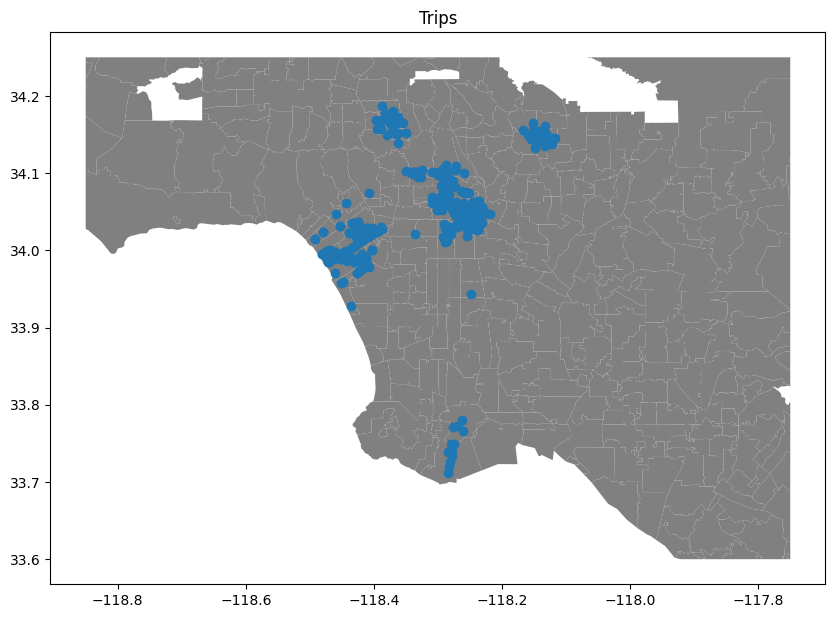

In [130]:
fig,ax = plt.subplots(figsize=(10,10))
base_layer.plot(ax=ax,color="grey")
gdf_bikestations.geometry.plot(ax=ax)
plt.title('Trips')

In [131]:
gdf_bikestations.sample(3)

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta
233,4436,2019-09-06 12:28:00,844,POINT (-118.29194 34.10578),121.285714,90027
9,3055,2016-10-01 07:24:00,7928,POINT (-118.25158 34.04416),274.142857,90014
296,4542,2020-07-30 12:51:00,83,POINT (-118.42394 33.97298),74.428571,90094


### Culling Down ZCTA Polygon Info

In [132]:
#gdf_bikestations = geopandas.sjoin(left_df=gdf_bikestations,right_df=base_layer, how='left')
#gdf_bikestations.drop(['index_right'],axis=1,inplace=True)

In [133]:
gdf_bikestations = gdf_bikestations.merge(df_traffic,left_on='zcta',right_on='zcta19')
gdf_bikestations.drop(['zcta19'],axis=1,inplace=True)

In [134]:
df_cdc_health.head()

,ZCTA5,Geolocation,TotalPopulation,OBESITY_CrudePrev,DEPRESSION_CrudePrev,SLEEP_CrudePrev,CSMOKING_CrudePrev,BPHIGH_CrudePrev,CANCER_Crude95CI
0,8240,POINT (-74.53173709 39.48730537),2371,NaN,NaN,35.8,NaN,NaN,NaN
1,7090,POINT (-74.3462755 40.64888869),30338,NaN,NaN,33.1,NaN,NaN,NaN
2,8865,POINT (-75.16934975 40.69233901),29840,NaN,NaN,38.9,NaN,NaN,NaN
3,7650,POINT (-73.99666187 40.84708222),19601,NaN,NaN,39.2,NaN,NaN,NaN
4,7719,POINT (-74.07252197 40.16876396),21538,NaN,NaN,36.1,NaN,NaN,NaN


In [135]:
gdf_bikestations = gdf_bikestations.merge(df_cdc_health,left_on='zcta',right_on='ZCTA5')
gdf_bikestations.drop(['ZCTA5'],axis=1,inplace=True)

In [136]:
gdf_bikestations.sample(3)

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta,year,i_mean_nonhw_traffic,i_mean_nh_traf_per_intersection,count_intersections,i_total_nonhw_traffic,Geolocation,TotalPopulation,OBESITY_CrudePrev,DEPRESSION_CrudePrev,SLEEP_CrudePrev,CSMOKING_CrudePrev,BPHIGH_CrudePrev,CANCER_Crude95CI
29,4475,2020-01-16 11:10:00,1961,POINT (-118.24325 34.04518),102.428571,90013,2014.0,20764.572266,177.474976,117.0,145352.0,POINT (-118.2343163 34.04314081),11772,33.9,14.8,41.5,17.7,37.2,"( 4.8, 5.0)"
20,4511,2020-10-12 07:58:00,565,POINT (-118.23177 34.05628),63.857143,90012,2017.0,158511.109375,269.119019,589.0,1426600.0,POINT (-118.240279 34.05840098),31103,23.0,11.9,39.7,13.7,27.8,"( 4.0, 4.2)"
345,4542,2020-07-30 12:51:00,83,POINT (-118.42394 33.97298),74.428571,90094,2013.0,45585.000000,747.295105,61.0,136755.0,POINT (-118.4169878 33.97541573),5464,19.9,14.6,33.7,7.3,17.0,"( 3.9, 4.1)"


In [137]:
gdf_bikestations =  geopandas.sjoin(left_df=gdf_bikestations,right_df=gdf_healthy_places,how='left')

In [138]:
test = gdf_bikestations[gdf_bikestations['Tree_Pct'].isnull()].copy(())

In [139]:
missingIndices =  test.index

In [140]:
test.columns

Index(['station_id', 'began_operation', 'total_number_of_trips', 'geometry',
       'time_in_operation', 'zcta', 'year', 'i_mean_nonhw_traffic',
       'i_mean_nh_traf_per_intersection', 'count_intersections',
       'i_total_nonhw_traffic', 'Geolocation', 'TotalPopulation',
       'OBESITY_CrudePrev', 'DEPRESSION_CrudePrev', 'SLEEP_CrudePrev',
       'CSMOKING_CrudePrev', 'BPHIGH_CrudePrev', 'CANCER_Crude95CI',
       'index_right', 'ZIP', 'HPI2_pctil', 'Top25', 'Sprmrkt_Pc', 'ParkAcc_Pc',
       'Retail_Pct', 'Tree_Pct'],
      dtype='object')

In [141]:
test.drop([ 'index_right', 'ZIP', 'HPI2_pctil', 'Top25', 'Sprmrkt_Pc', 'ParkAcc_Pc',
       'Retail_Pct', 'Tree_Pct'],axis=1,inplace=True)

In [142]:
test = test.merge(gdf_healthy_places,left_on='zcta',right_on='ZIP',how='left')

In [143]:
test = test.loc[missingIndices]

In [144]:
gdf_bikestations.iloc[missingIndices] = test

In [145]:
gdf_bikestations.drop(['index_right'],axis=1,inplace=True)

In [146]:
gdf_bikestations.drop(['ZIP'],axis=1,inplace=True)

In [155]:
missingZCTAs =  gdf_bikestations[gdf_bikestations['Tree_Pct'].isna()]

12    -118.243530
16    -118.243530
84    -118.231773
86    -118.231773
149   -118.277687
163   -118.281807
166   -118.281807
190   -118.166686
352   -118.402313
dtype: float64

In [157]:
# Interpolate
from shapely import Point
from scipy.spatial import cKDTree

In [210]:
def ck_nearest(gdfA, gdfB):
    # Takes the gps coordinates and creates two arrays
    nA = np.array(list(gdfA.geometry.apply(lambda x: (x.x , x.y))))
    nB = np.array(list(gdfB.geometry.apply(lambda x: (x.x , x.y )))) 

    btree = cKDTree(nB)   
    distance , idx = btree.query(nA, k=1)

    gdfB_nearest_points = gdfB.iloc[idx].drop(columns='geometry')

    gdfB_nearest_points.index = gdfA.index

    

    return gdfB_nearest_points

In [216]:
interpolatedStations = ck_nearest(missingZCTAs,gdf_bikestations)

Int64Index([12, 16, 84, 86, 149, 163, 166, 190, 352], dtype='int64')


In [218]:
gdf_bikestations.update(interpolatedStations)

In [220]:
gdf_bikestations

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta,year,i_mean_nonhw_traffic,i_mean_nh_traf_per_intersection,count_intersections,...,SLEEP_CrudePrev,CSMOKING_CrudePrev,BPHIGH_CrudePrev,CANCER_Crude95CI,HPI2_pctil,Top25,Sprmrkt_Pc,ParkAcc_Pc,Retail_Pct,Tree_Pct
0,3028.0,2016-10-01 04:10:00,6904.0,POINT (-118.24609 34.05832),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",19.748492,No,92.975298,100.000000,2.152385,3.774844
1,3066.0,2016-10-01 13:18:00,11700.0,POINT (-118.23616 34.06339),274.000000,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",0.628769,No,100.000000,100.000000,25.969275,2.657313
2,3078.0,2016-10-01 01:33:00,6184.0,POINT (-118.23894 34.06428),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",0.628769,No,100.000000,100.000000,25.969275,2.657313
3,3082.0,2016-10-01 02:41:00,24352.0,POINT (-118.23741 34.04652),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",72.757603,No,94.530562,100.000000,1.414428,4.185775
4,3022.0,2016-10-01 01:33:00,18000.0,POINT (-118.23309 34.04607),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",72.757603,No,94.530562,100.000000,1.414428,4.185775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,4499.0,2020-03-08 11:19:00,120.0,POINT (-118.38801 34.18657),95.000000,91606,2017.0,206000.000000,439.232422,469.0,...,36.9,13.5,26.1,"( 5.0, 5.1)",34.543821,No,94.035522,54.844440,6.827290,5.890619
357,4498.0,2020-04-22 14:37:00,96.0,POINT (-118.37042 34.17989),88.428571,91606,2017.0,206000.000000,439.232422,469.0,...,36.9,13.5,26.1,"( 5.0, 5.1)",42.230207,No,99.938832,100.000000,2.909261,5.517040
358,4526.0,2021-10-03 18:22:00,67.0,POINT (-118.34919 34.10338),12.857143,90046,2014.0,7667.631348,12.952080,592.0,...,32.8,9.6,22.7,"( 5.8, 6.0)",62.171179,No,100.000000,100.000000,7.429162,3.765705
359,4593.0,2021-12-05 08:30:00,69.0,POINT (-118.33520 34.02097),4.000000,90016,2017.0,308000.000000,565.137634,545.0,...,40.7,13.9,31.1,"( 4.7, 4.8)",56.114462,No,40.613682,100.000000,3.078097,3.968613


In [223]:
gdf_bikestations.iloc[missingZCTAs.index]

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta,year,i_mean_nonhw_traffic,i_mean_nh_traf_per_intersection,count_intersections,...,SLEEP_CrudePrev,CSMOKING_CrudePrev,BPHIGH_CrudePrev,CANCER_Crude95CI,HPI2_pctil,Top25,Sprmrkt_Pc,ParkAcc_Pc,Retail_Pct,Tree_Pct
12,3030.0,2016-10-01 11:15:00,36616.0,POINT (-118.24353 34.05194),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",16.720133,No,100.000000,100.0000,8.476671,4.180637
16,3030.0,2016-10-01 11:15:00,36616.0,POINT (-118.24353 34.05194),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",16.720133,No,100.000000,100.0000,8.476671,4.180637
84,4511.0,2020-10-12 07:58:00,565.0,POINT (-118.23177 34.05628),63.857143,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",85.794944,Yes,4.640994,100.0000,144.523502,4.139024
86,4511.0,2020-10-12 07:58:00,565.0,POINT (-118.23177 34.05628),63.857143,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",85.794944,Yes,4.640994,100.0000,144.523502,4.139024
149,4266.0,2018-12-01 15:56:00,4587.0,POINT (-118.27769 34.02629),161.000000,90007,2017.0,352500.000000,687.134521,513.0,...,39.1,13.6,21.8,"( 2.8, 2.8)",NaN,None,NaN,NaN,NaN,NaN
163,4441.0,2019-09-11 08:57:00,938.0,POINT (-118.28181 34.02662),120.571429,90007,2017.0,352500.000000,687.134521,513.0,...,39.1,13.6,21.8,"( 2.8, 2.8)",18.247145,No,100.000000,59.5524,4.503683,4.473843
166,4441.0,2019-09-11 08:57:00,938.0,POINT (-118.28181 34.02662),120.571429,90007,2017.0,352500.000000,687.134521,513.0,...,39.1,13.6,21.8,"( 2.8, 2.8)",18.247145,No,100.000000,59.5524,4.503683,4.473843
190,4153.0,2017-07-14 12:35:00,2717.0,POINT (-118.16669 34.15618),233.285714,91103,2018.0,1818.548340,3.056384,595.0,...,37.4,12.2,29.2,"( 5.3, 5.4)",NaN,None,NaN,NaN,NaN,NaN
352,4381.0,2019-04-17 15:27:00,219.0,POINT (-118.40231 34.00006),141.428571,90230,2017.0,226500.000000,279.629639,810.0,...,34.1,9.1,25.7,"( 6.0, 6.1)",NaN,None,NaN,NaN,NaN,NaN


In [221]:
gdf_bikestations

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta,year,i_mean_nonhw_traffic,i_mean_nh_traf_per_intersection,count_intersections,...,SLEEP_CrudePrev,CSMOKING_CrudePrev,BPHIGH_CrudePrev,CANCER_Crude95CI,HPI2_pctil,Top25,Sprmrkt_Pc,ParkAcc_Pc,Retail_Pct,Tree_Pct
0,3028.0,2016-10-01 04:10:00,6904.0,POINT (-118.24609 34.05832),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",19.748492,No,92.975298,100.000000,2.152385,3.774844
1,3066.0,2016-10-01 13:18:00,11700.0,POINT (-118.23616 34.06339),274.000000,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",0.628769,No,100.000000,100.000000,25.969275,2.657313
2,3078.0,2016-10-01 01:33:00,6184.0,POINT (-118.23894 34.06428),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",0.628769,No,100.000000,100.000000,25.969275,2.657313
3,3082.0,2016-10-01 02:41:00,24352.0,POINT (-118.23741 34.04652),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",72.757603,No,94.530562,100.000000,1.414428,4.185775
4,3022.0,2016-10-01 01:33:00,18000.0,POINT (-118.23309 34.04607),274.142857,90012,2017.0,158511.109375,269.119019,589.0,...,39.7,13.7,27.8,"( 4.0, 4.2)",72.757603,No,94.530562,100.000000,1.414428,4.185775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,4499.0,2020-03-08 11:19:00,120.0,POINT (-118.38801 34.18657),95.000000,91606,2017.0,206000.000000,439.232422,469.0,...,36.9,13.5,26.1,"( 5.0, 5.1)",34.543821,No,94.035522,54.844440,6.827290,5.890619
357,4498.0,2020-04-22 14:37:00,96.0,POINT (-118.37042 34.17989),88.428571,91606,2017.0,206000.000000,439.232422,469.0,...,36.9,13.5,26.1,"( 5.0, 5.1)",42.230207,No,99.938832,100.000000,2.909261,5.517040
358,4526.0,2021-10-03 18:22:00,67.0,POINT (-118.34919 34.10338),12.857143,90046,2014.0,7667.631348,12.952080,592.0,...,32.8,9.6,22.7,"( 5.8, 6.0)",62.171179,No,100.000000,100.000000,7.429162,3.765705
359,4593.0,2021-12-05 08:30:00,69.0,POINT (-118.33520 34.02097),4.000000,90016,2017.0,308000.000000,565.137634,545.0,...,40.7,13.9,31.1,"( 4.7, 4.8)",56.114462,No,40.613682,100.000000,3.078097,3.968613


In [188]:
stationsToInterpolate

,station_id,began_operation,total_number_of_trips,geometry,time_in_operation,zcta,year,i_mean_nonhw_traffic,i_mean_nh_traf_per_intersection,count_intersections,...,SLEEP_CrudePrev,CSMOKING_CrudePrev,BPHIGH_CrudePrev,CANCER_Crude95CI,HPI2_pctil,Top25,Sprmrkt_Pc,ParkAcc_Pc,Retail_Pct,Tree_Pct
12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
16,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
84,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
86,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
149,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
163,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
166,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
190,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
352,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True


In [ ]:
for ZCTA in missingZCTAs:
    gdf_bikestations

Text(0.5, 1.0, 'Trips')

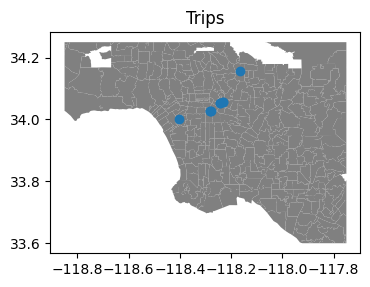

In [ ]:

fig,ax = plt.subplots(figsize=(4,4))
base_layer.plot(ax=ax,color="grey")
gdf_bikestations[gdf_bikestations['Tree_Pct'].isna()].plot(ax=ax)
plt.title('Trips')


## Preprocessing More Data

In [ ]:
gdf 

3460    92657
376     92651
156     92651
26      92657
25      92660
        ...  
3436    91740
2852    91740
3796    91750
2939    91741
3452    91711
Name: ZIP, Length: 2595, dtype: object